In [62]:
# ===============================
# 📦 FeSViBS Notebook: Setup
# ===============================

import os
import random
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# MedMNIST
import medmnist
from medmnist import INFO
from medmnist import BloodMNIST

# Reproducibility
def set_seed(seed=105):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(105)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [63]:
def blood_noniid(num_clients, dataset, batch_size):
    """
    Reimplementation of FeSViBS repo's blood_noniid function.
    Biases specific classes toward certain clients (non-IID).
    Returns list of DataLoaders, one per client.
    """

    # Step 1: Extract image-label pairs
    labels = get_labels(dataset)
    data = [(i, int(labels[i])) for i in range(len(dataset))]

    # Initialize per-client indices
    client_indices = [[] for _ in range(num_clients)]

    for idx, label in data:
        # Initialize equal probabilities
        p = np.ones(num_clients)

        # Manually bias probabilities for specific classes
        if label == 0:
            p[0] = num_clients
            p[1] = num_clients
            p[2] = num_clients
        elif label == 1:
            p[0] = num_clients
            p[1] = num_clients
            p[2] = num_clients
        elif label == 2:
            p[1] = num_clients
            p[3] = num_clients
            p[4] = num_clients
        elif label == 3:
            p[3] = num_clients
            p[4] = num_clients
            p[5] = num_clients
        elif label == 4:
            p[2] = num_clients
            p[3] = num_clients
            p[4] = num_clients
        elif label == 5:
            p[0] = num_clients
            p[1] = num_clients
            p[5] = num_clients
        elif label == 6:
            p[0] = num_clients
            p[4] = num_clients
            p[5] = num_clients
        elif label == 7:
            p[1] = num_clients
            p[2] = num_clients
            p[3] = num_clients

        # Normalize to sum 1
        p = p / p.sum()

        # Sample a client index using this biased distribution
        client_id = np.random.choice(np.arange(num_clients), p=p)
        client_indices[client_id].append(idx)

    # Step 2: Wrap indices into Subsets and DataLoaders
    client_datasets = [torch.utils.data.Subset(dataset, idxs) for idxs in client_indices]
    client_loaders = [
        DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=2)
        for ds in client_datasets
    ]

    return client_datasets, client_loaders


In [64]:
# ===============================
# 🩸 Step 2: Load BloodMNIST (subset or full dataset)
# ===============================

# Parameters
input_size = 224
num_clients = 6
use_subset = True
subset_fraction = 0.05
root = './data'

# Transforms
transform_train = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(input_size, scale=(0.75, 1), ratio=(0.9, 1)),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
])

# Load dataset
data_flag = 'bloodmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
train_full = DataClass(split='train', transform=transform_train, download=True, root=root)
test_full = DataClass(split='test', transform=transform_test, download=True, root=root)

def get_subset(dataset, fraction):
    total = len(dataset)
    subset_size = int(total * fraction)
    indices = torch.randperm(total)[:subset_size]
    return torch.utils.data.Subset(dataset, indices)

# Choose full or subset
train_dataset = get_subset(train_full, subset_fraction) if use_subset else train_full
test_dataset = get_subset(test_full, subset_fraction) if use_subset else test_full

# Adjust batch size if needed
batch_size = min(32, max(2, len(train_dataset) // (num_clients * 2)))


Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz


In [65]:
# # Split among clients for iid 
# def split_dataset(dataset, num_clients):
#     base = len(dataset) // num_clients
#     remainder = len(dataset) % num_clients
#     sizes = [base] * num_clients
#     sizes[-1] += remainder
#     return random_split(dataset, sizes)

# client_datasets = split_dataset(train_dataset, num_clients)
# client_loaders = [DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=2) for ds in client_datasets]
# test_loader = DataLoader(test_dataset, batch_size=2*batch_size, shuffle=False, num_workers=2)

In [66]:
client_datasets, client_loaders = blood_noniid(num_clients, train_dataset, batch_size)
test_loader = DataLoader(test_dataset, batch_size=2*batch_size, shuffle=False, num_workers=2)

In [67]:
print("Training Samples:", len(train_dataset))
print("Testing Samples:", len(test_dataset))

Training Samples: 597
Testing Samples: 171


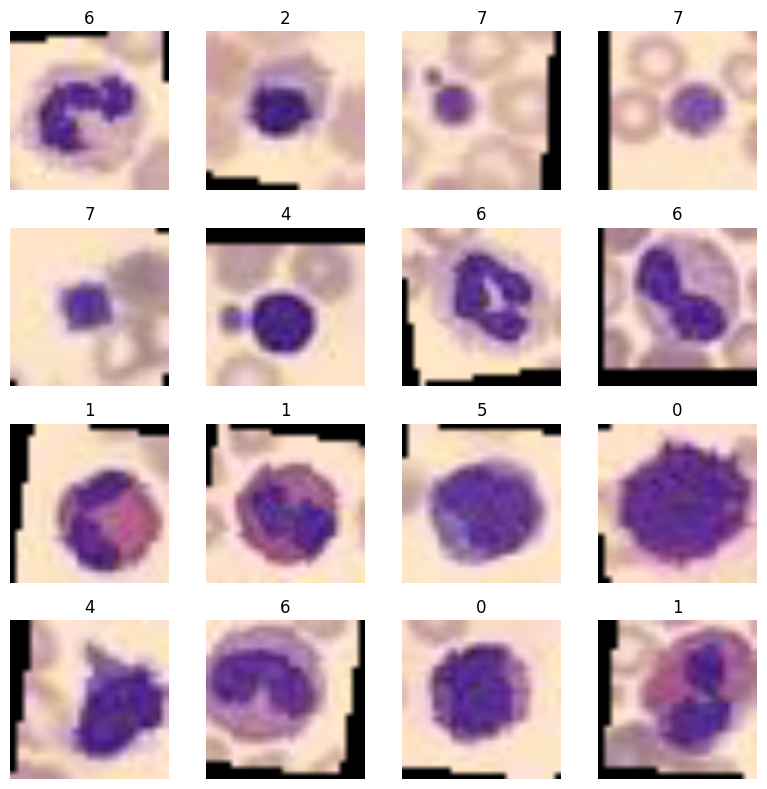

In [68]:
# Load a batch of images
images, labels = next(iter(torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)))
class_names = getattr(train_dataset, 'classes', [str(i) for i in range(8)])

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i].permute(1, 2, 0).numpy())
    ax.set_title(class_names[labels[i]])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [69]:
def get_labels(dataset):
    """
    Recursively unwraps Subset objects to access the original dataset's labels.
    Returns the labels corresponding to the provided (subset) dataset.
    """
    indices = None

    # Unwrap until we reach the base dataset
    while isinstance(dataset, torch.utils.data.Subset):
        if indices is None:
            indices = dataset.indices
        else:
            indices = [dataset.indices[i] for i in indices]
        dataset = dataset.dataset

    # Get labels from the base dataset
    labels = dataset.labels
    if indices is not None:
        labels = labels[indices]

    return labels.flatten()


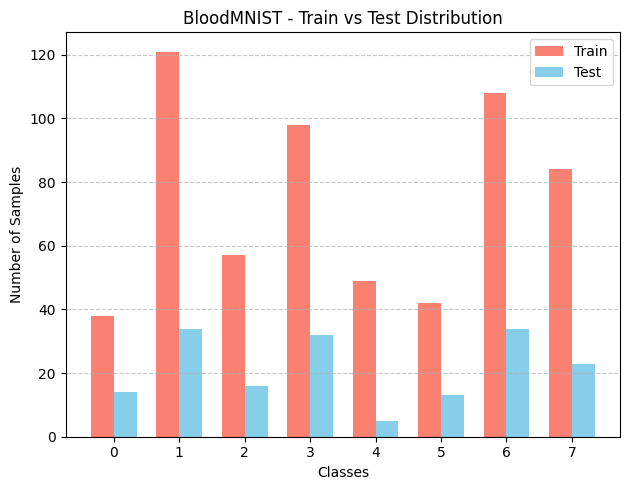

In [70]:

def count_labels(labels, num_classes=None):
    """
    Counts occurrences of each label, ensuring all classes are represented.
    """
    counts = Counter(labels)
    if num_classes is None:
        num_classes = max(counts.keys()) + 1
    return [counts.get(i, 0) for i in range(num_classes)]

def plot_class_distribution(train_dataset, test_dataset, title="Train vs Test Distribution"):
    """
    Plots the distribution of class labels in train and test datasets using class encodings.
    """
    # Get labels
    train_labels = get_labels(train_dataset)
    test_labels = get_labels(test_dataset)

    # Count occurrences
    num_classes = max(train_labels.max(), test_labels.max()) + 1
    train_counts = count_labels(train_labels, num_classes)
    test_counts = count_labels(test_labels, num_classes)

    # Plot settings
    x = np.arange(num_classes)
    width = 0.35
    # class_names = info['label']  # e.g., {'0': 'neutrophil', ...}
    # labels = [class_names[str(i)] for i in x]

    # Plot
    plt.figure(figsize=(max(6, 0.8 * num_classes), 5))
    plt.bar(x - width/2, train_counts, width, label='Train', color='salmon')
    plt.bar(x + width/2, test_counts, width, label='Test', color='skyblue')
    plt.xticks(x, [str(i) for i in x], rotation=0)
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.title(f"BloodMNIST - {title}")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_class_distribution(train_dataset, test_dataset)


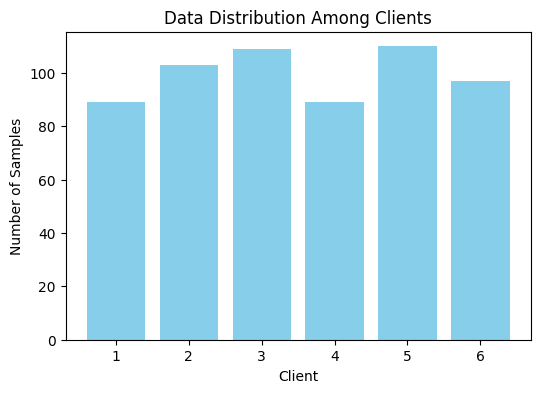

[89, 103, 109, 89, 110, 97]


In [71]:
client_sizes = [len(ds) for ds in client_datasets]

# Plotting
plt.figure(figsize=(6,4))
plt.bar(range(1, len(client_sizes)+1), client_sizes, color='skyblue')
plt.xlabel('Client')
plt.ylabel('Number of Samples')
plt.title('Data Distribution Among Clients')
plt.xticks(range(1, len(client_sizes)+1))
plt.show()

print(client_sizes)

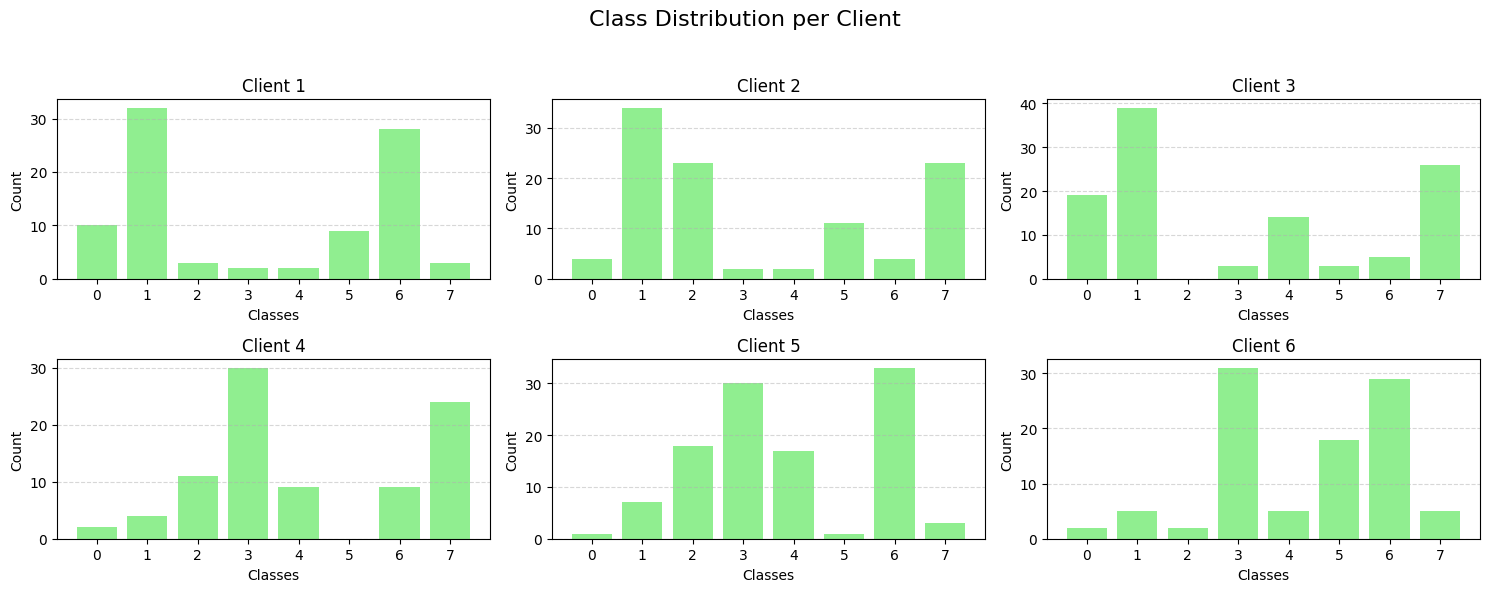

In [72]:
# %%
from collections import Counter

def plot_client_class_distributions(client_datasets, num_classes=8):
    """
    Plots the class distribution for each client in a separate subplot.
    """
    fig, axs = plt.subplots(2, (len(client_datasets) + 1) // 2, figsize=(15, 6))
    axs = axs.flatten()

    for i, dataset in enumerate(client_datasets):
        # Extract labels
        labels = get_labels(dataset)
        counts = count_labels(labels, num_classes)

        # Plot
        axs[i].bar(range(num_classes), counts, color='lightgreen')
        axs[i].set_title(f'Client {i+1}')
        axs[i].set_xlabel('Classes')
        axs[i].set_ylabel('Count')
        axs[i].set_xticks(range(num_classes))
        axs[i].set_xticklabels([str(i) for i in range(num_classes)])
        axs[i].grid(axis='y', linestyle='--', alpha=0.5)

    # Remove unused subplots
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])

    plt.suptitle('Class Distribution per Client', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Call the function
plot_client_class_distributions(client_datasets)


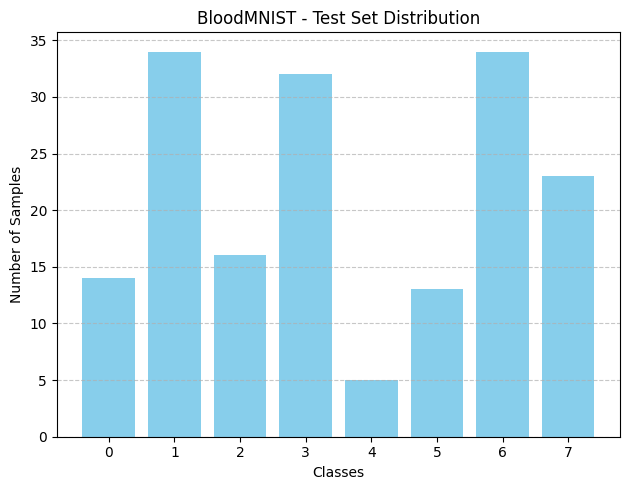

In [73]:
# %%
def plot_test_class_distribution(test_dataset, title="Test Set Distribution", num_classes=8):
    """
    Plots the distribution of class labels in the test dataset only.
    """
    test_labels = get_labels(test_dataset)
    test_counts = count_labels(test_labels, num_classes)

    x = np.arange(num_classes)
    
    plt.figure(figsize=(max(6, 0.8 * num_classes), 5))
    plt.bar(x, test_counts, color='skyblue')
    plt.xticks(x, [str(i) for i in x])
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.title(f"BloodMNIST - {title}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Call the function
plot_test_class_distribution(test_dataset)


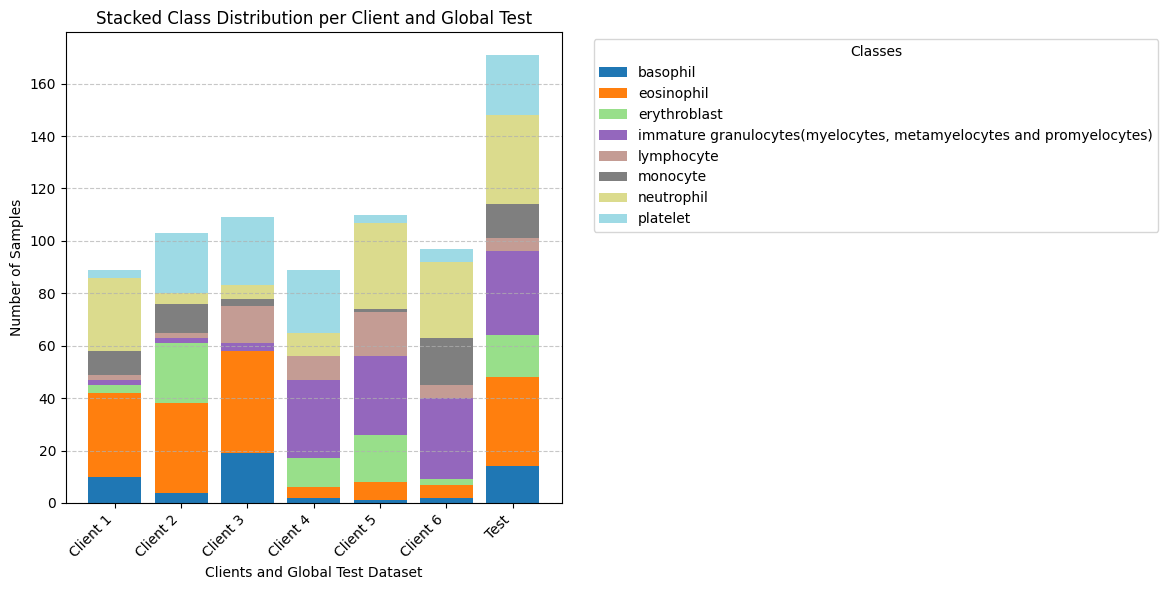

In [74]:
# %%
def plot_stacked_distribution_by_client(client_datasets, test_dataset, num_classes=8):
    """
    Plots a stacked bar chart where each bar corresponds to a client or the test dataset,
    and each segment represents the count of a specific class.
    """

    labels = [f'Client {i+1}' for i in range(len(client_datasets))] + ['Test']

    # Collect counts per client/test: shape (num_clients+1, num_classes)
    all_counts = []

    for dataset in client_datasets:
        labels_arr = get_labels(dataset)
        counts = count_labels(labels_arr, num_classes)
        all_counts.append(counts)

    test_labels_arr = get_labels(test_dataset)
    test_counts = count_labels(test_labels_arr, num_classes)
    all_counts.append(test_counts)

    all_counts = np.array(all_counts)  # shape: (num_clients+1, num_classes)

    # Plot stacked bars
    x = np.arange(len(labels))

    import matplotlib.cm as cm
    cmap = cm.get_cmap('tab20', num_classes)
    colors = [cmap(i) for i in range(num_classes)]

    plt.figure(figsize=(12, 6))

    bottom = np.zeros(len(labels))
    for class_idx in range(num_classes):
        plt.bar(x, all_counts[:, class_idx], bottom=bottom, color=colors[class_idx],
                label=info['label'][str(class_idx)] if 'label' in info else str(class_idx))
        bottom += all_counts[:, class_idx]

    plt.xticks(x, labels, rotation=45, ha='right')
    plt.xlabel('Clients and Global Test Dataset')
    plt.ylabel('Number of Samples')
    plt.title('Stacked Class Distribution per Client and Global Test')
    plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Call the function
plot_stacked_distribution_by_client(client_datasets, test_dataset)


### step 3

In [75]:
import torch.nn as nn

class MLP_cls_classes(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.norm = nn.LayerNorm((768,), eps=1e-6)
        self.fc = nn.Linear(in_features=768, out_features=num_classes)

    def forward(self, x):
        x = self.norm(x)
        x = self.fc(x)
        return x


In [76]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels=768, out_channels=768, drop_out=0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(14, stride=1)
        self.dropout = nn.Dropout2d(p=drop_out)

    def forward(self, x):
        if len(x.shape) == 3:
            # [B, Tokens, Channels] → [B, C, H, W]
            x = torch.permute(x, (0, 2, 1))
            x = x.reshape(x.shape[0], x.shape[1], 14, 14)
        residual = x
        out = self.conv1(x)
        out = self.dropout(out)
        out = self.conv2(out)
        out += residual
        out = self.relu(out)
        out = self.pool(out)
        return out.view(out.size(0), -1)  # Flatten


In [77]:
import timm

class FeSVBiS(nn.Module):
    def __init__(self, ViT_name, num_classes, num_clients=6, in_channels=3,
                 ViT_pretrained=False, initial_block=1, final_block=6,
                 resnet_dropout=0.5, DP=False, mean=0.0, std=0.0):
        super().__init__()
        self.initial_block = initial_block
        self.final_block = final_block
        self.num_clients = num_clients
        self.DP = DP
        self.mean = mean
        self.std = std

        # Load ViT model
        self.vit = timm.create_model(
            model_name=ViT_name,
            pretrained=ViT_pretrained,
            num_classes=num_classes,
            in_chans=in_channels
        )

        # Split components
        self.patch_embed = self.vit.patch_embed
        self.resnet50_clients = nn.ModuleList([
            nn.Sequential(self.patch_embed) for _ in range(num_clients)
        ])
        self.common_network = ResidualBlock(drop_out=resnet_dropout)

        # Tail classifiers per client
        tail = MLP_cls_classes(num_classes)
        self.mlp_clients_tail = nn.ModuleList([tail for _ in range(num_clients)])

    def forward(self, x, chosen_block, client_idx):
        # Client-side patch embedding
        x = self.resnet50_clients[client_idx](x)  # shape: [B, C, H, W] → patch tokens

        # Add DP noise if enabled
        if self.DP:
            noise = torch.randn_like(x) * self.std + self.mean
            x = x + noise

        # Transformer forward through sampled blocks
        for block_num in range(chosen_block):
            x = self.vit.blocks[block_num](x)

        # Common block and tail
        x = self.common_network(x)
        x = self.mlp_clients_tail[client_idx](x)
        return x


In [78]:
# Test: Instantiate and forward pass with dummy image
model = FeSVBiS(
    ViT_name='vit_base_r50_s16_224',
    num_classes=8,
    num_clients=num_clients,
    ViT_pretrained=False,
    DP=False
).to(device)

dummy_input = torch.randn(2, 3, 224, 224).to(device)
output = model(dummy_input, chosen_block=3, client_idx=0)
print("Output shape:", output.shape)  # Expect: [2, 8]


Output shape: torch.Size([2, 8])


In [79]:
def average_weights(w_list):
    """ Federated averaging of model weights """
    avg_weights = {}
    for key in w_list[0].keys():
        avg_weights[key] = sum(w[key] for w in w_list) / len(w_list)
    return avg_weights


In [80]:
class SplitFeSViBSNotebook:
    def __init__(self, model, client_loaders, test_loader, num_clients, criterion, optimizer_fn, device):
        self.model = model
        self.client_loaders = client_loaders
        self.test_loader = test_loader
        self.num_clients = num_clients
        self.device = device
        self.criterion = criterion
        self.optimizer_fn = optimizer_fn

        # One optimizer per client
        self.optimizers = [
            self.optimizer_fn(
                list(self.model.resnet50_clients[i].parameters()) +
                list(self.model.mlp_clients_tail[i].parameters())
            ) for i in range(num_clients)
        ]

    def train_round(self, client_idx, chosen_block):
        self.model.train()
        loader = self.client_loaders[client_idx]
        optimizer = self.optimizers[client_idx]

        running_loss = 0.0
        total_correct = 0
        total_samples = 0

        for x, y in loader:
            x, y = x.to(self.device), y.view(-1).to(self.device)

            optimizer.zero_grad()
            outputs = self.model(x, chosen_block, client_idx)
            loss = self.criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += x.size(0)

        avg_loss = running_loss / total_samples
        accuracy = total_correct / total_samples

        # Return model weights for this client
        weights = {
            f"resnet_{client_idx}": {k: v.cpu().detach().clone() for k, v in self.model.resnet50_clients[client_idx].state_dict().items()},
            f"tail_{client_idx}": {k: v.cpu().detach().clone() for k, v in self.model.mlp_clients_tail[client_idx].state_dict().items()}
        }

        return avg_loss, accuracy, {
            f"resnet_{client_idx}": {k: v.cpu().detach().clone() for k, v in self.model.resnet50_clients[client_idx].state_dict().items()},
            f"tail_{client_idx}": {k: v.cpu().detach().clone() for k, v in self.model.mlp_clients_tail[client_idx].state_dict().items()}
        }


    def eval_client(self, client_idx, chosen_block):
        self.model.eval()
        loader = self.test_loader
        correct = 0
        total = 0

        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.squeeze().to(self.device)
                outputs = self.model(x, chosen_block, client_idx)
                preds = outputs.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += x.size(0)

        return correct / total if total > 0 else 0.0

    def federated_aggregate(self, weight_dicts):
        """ Safe federated averaging over available client weights """

        resnet_keys = [f"resnet_{i}" for i in range(self.num_clients)]
        tail_keys = [f"tail_{i}" for i in range(self.num_clients)]

        for key_group in [resnet_keys, tail_keys]:
            for key in key_group:
                available_weights = []
                for w in weight_dicts:
                    if key in w:
                        available_weights.append(w[key])
                if not available_weights:
                    continue  # Skip if no client provided weights for this part
                avg_state = average_weights(available_weights)

                client_idx = int(key.split('_')[-1])
                target_module = self.model.resnet50_clients[client_idx] if 'resnet' in key else self.model.mlp_clients_tail[client_idx]
                target_module.load_state_dict(avg_state)
                print(f"Aggregating {key} from {len(available_weights)} clients")




In [81]:
import torch.optim as optim

# Instantiate model again (if needed)
model = FeSVBiS(
    ViT_name='vit_base_r50_s16_224',
    num_classes=8,
    num_clients=num_clients,
    ViT_pretrained=False,
    DP=False
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_fn = lambda params: optim.Adam(params, lr=1e-4)

# Create training manager
trainer = SplitFeSViBSNotebook(
    model=model,
    client_loaders=client_loaders,
    test_loader=test_loader,
    num_clients=num_clients,
    criterion=criterion,
    optimizer_fn=optimizer_fn,
    device=device
)


In [82]:
# ===============================
# 🏁 FeSViBS Training Configuration
# ===============================
epochs = 10 if use_subset else 50
local_round = 2  # how often to aggregate weights
initial_block = 1
final_block = 6

# Tracking metrics
train_losses = [[] for _ in range(num_clients)]
train_accuracies = [[] for _ in range(num_clients)]
test_accuracies = [[] for _ in range(num_clients)]


In [83]:
# ===============================
# 🔁 FeSViBS Training Loop
# ===============================
from tqdm import trange
import random

for epoch in trange(epochs, desc="Training Epochs"):
    weight_dicts = []
    print(f"\n🌀 Epoch {epoch+1}/{epochs}")

    for client_idx in range(num_clients):
        # Randomly sample a block for each client each epoch
        chosen_block = random.randint(initial_block, final_block)

        loss, acc, weights = trainer.train_round(client_idx, chosen_block)
        weight_dicts.append(weights)

        train_losses[client_idx].append(loss)
        train_accuracies[client_idx].append(acc)

        print(f"Client {client_idx+1}: Block={chosen_block} | Train Acc={acc:.2f}, Loss={loss:.4f}")

    # Federated aggregation every few rounds
    if (epoch + 1) % local_round == 0:
        trainer.federated_aggregate(weight_dicts)
        print("✅ Federated weights aggregated.")

    # Evaluate test accuracy for each client
    for client_idx in range(num_clients):
        chosen_block = random.randint(initial_block, final_block)
        acc = trainer.eval_client(client_idx, chosen_block)
        test_accuracies[client_idx].append(acc)
        print(f"📊 Client {client_idx+1} → Test Accuracy = {acc:.2f}")


Training Epochs:   0%|          | 0/10 [00:00<?, ?it/s]


🌀 Epoch 1/10
Client 1: Block=5 | Train Acc=0.26, Loss=1.8262
Client 2: Block=3 | Train Acc=0.36, Loss=1.8253
Client 3: Block=5 | Train Acc=0.59, Loss=1.4523
Client 4: Block=1 | Train Acc=0.45, Loss=1.6759
Client 5: Block=1 | Train Acc=0.42, Loss=1.5369
Client 6: Block=3 | Train Acc=0.42, Loss=1.6833
📊 Client 1 → Test Accuracy = 0.37
📊 Client 2 → Test Accuracy = 0.37
📊 Client 3 → Test Accuracy = 0.40
📊 Client 4 → Test Accuracy = 0.40
📊 Client 5 → Test Accuracy = 0.30


Training Epochs:  10%|█         | 1/10 [00:11<01:41, 11.32s/it]

📊 Client 6 → Test Accuracy = 0.40

🌀 Epoch 2/10
Client 1: Block=2 | Train Acc=0.33, Loss=1.9403
Client 2: Block=2 | Train Acc=0.49, Loss=1.6272
Client 3: Block=1 | Train Acc=0.52, Loss=1.5940
Client 4: Block=6 | Train Acc=0.35, Loss=1.9086
Client 5: Block=4 | Train Acc=0.48, Loss=1.6190
Client 6: Block=3 | Train Acc=0.45, Loss=1.3694
Aggregating resnet_0 from 1 clients
Aggregating resnet_1 from 1 clients
Aggregating resnet_2 from 1 clients
Aggregating resnet_3 from 1 clients
Aggregating resnet_4 from 1 clients
Aggregating resnet_5 from 1 clients
Aggregating tail_0 from 1 clients
Aggregating tail_1 from 1 clients
Aggregating tail_2 from 1 clients
Aggregating tail_3 from 1 clients
Aggregating tail_4 from 1 clients
Aggregating tail_5 from 1 clients
✅ Federated weights aggregated.
📊 Client 1 → Test Accuracy = 0.46
📊 Client 2 → Test Accuracy = 0.44
📊 Client 3 → Test Accuracy = 0.44
📊 Client 4 → Test Accuracy = 0.44
📊 Client 5 → Test Accuracy = 0.44


Training Epochs:  20%|██        | 2/10 [00:23<01:32, 11.58s/it]

📊 Client 6 → Test Accuracy = 0.44

🌀 Epoch 3/10
Client 1: Block=6 | Train Acc=0.34, Loss=1.7083
Client 2: Block=2 | Train Acc=0.57, Loss=1.1340
Client 3: Block=6 | Train Acc=0.59, Loss=1.1918
Client 4: Block=2 | Train Acc=0.34, Loss=1.6894
Client 5: Block=5 | Train Acc=0.61, Loss=1.3737
Client 6: Block=3 | Train Acc=0.47, Loss=1.4035
📊 Client 1 → Test Accuracy = 0.46
📊 Client 2 → Test Accuracy = 0.43
📊 Client 3 → Test Accuracy = 0.49
📊 Client 4 → Test Accuracy = 0.43
📊 Client 5 → Test Accuracy = 0.46


Training Epochs:  30%|███       | 3/10 [00:34<01:20, 11.54s/it]

📊 Client 6 → Test Accuracy = 0.49

🌀 Epoch 4/10
Client 1: Block=3 | Train Acc=0.37, Loss=1.6455
Client 2: Block=6 | Train Acc=0.51, Loss=1.3536
Client 3: Block=6 | Train Acc=0.58, Loss=1.1171
Client 4: Block=2 | Train Acc=0.51, Loss=1.3872
Client 5: Block=6 | Train Acc=0.54, Loss=1.3500
Client 6: Block=4 | Train Acc=0.55, Loss=1.3874
Aggregating resnet_0 from 1 clients
Aggregating resnet_1 from 1 clients
Aggregating resnet_2 from 1 clients
Aggregating resnet_3 from 1 clients
Aggregating resnet_4 from 1 clients
Aggregating resnet_5 from 1 clients
Aggregating tail_0 from 1 clients
Aggregating tail_1 from 1 clients
Aggregating tail_2 from 1 clients
Aggregating tail_3 from 1 clients
Aggregating tail_4 from 1 clients
Aggregating tail_5 from 1 clients
✅ Federated weights aggregated.
📊 Client 1 → Test Accuracy = 0.41
📊 Client 2 → Test Accuracy = 0.41
📊 Client 3 → Test Accuracy = 0.41
📊 Client 4 → Test Accuracy = 0.42
📊 Client 5 → Test Accuracy = 0.42


Training Epochs:  40%|████      | 4/10 [00:47<01:12, 12.14s/it]

📊 Client 6 → Test Accuracy = 0.44

🌀 Epoch 5/10
Client 1: Block=5 | Train Acc=0.48, Loss=1.2680
Client 2: Block=5 | Train Acc=0.56, Loss=1.0952
Client 3: Block=4 | Train Acc=0.65, Loss=0.9334
Client 4: Block=5 | Train Acc=0.43, Loss=1.5012
Client 5: Block=3 | Train Acc=0.58, Loss=1.1594
Client 6: Block=5 | Train Acc=0.52, Loss=1.2530
📊 Client 1 → Test Accuracy = 0.54
📊 Client 2 → Test Accuracy = 0.61
📊 Client 3 → Test Accuracy = 0.53
📊 Client 4 → Test Accuracy = 0.52
📊 Client 5 → Test Accuracy = 0.50


Training Epochs:  50%|█████     | 5/10 [00:59<00:59, 11.98s/it]

📊 Client 6 → Test Accuracy = 0.50

🌀 Epoch 6/10
Client 1: Block=6 | Train Acc=0.60, Loss=1.0954
Client 2: Block=3 | Train Acc=0.69, Loss=0.8916
Client 3: Block=5 | Train Acc=0.75, Loss=0.7292
Client 4: Block=2 | Train Acc=0.57, Loss=1.1200
Client 5: Block=1 | Train Acc=0.56, Loss=1.1531
Client 6: Block=5 | Train Acc=0.67, Loss=1.1280
Aggregating resnet_0 from 1 clients
Aggregating resnet_1 from 1 clients
Aggregating resnet_2 from 1 clients
Aggregating resnet_3 from 1 clients
Aggregating resnet_4 from 1 clients
Aggregating resnet_5 from 1 clients
Aggregating tail_0 from 1 clients
Aggregating tail_1 from 1 clients
Aggregating tail_2 from 1 clients
Aggregating tail_3 from 1 clients
Aggregating tail_4 from 1 clients
Aggregating tail_5 from 1 clients
✅ Federated weights aggregated.
📊 Client 1 → Test Accuracy = 0.62
📊 Client 2 → Test Accuracy = 0.62
📊 Client 3 → Test Accuracy = 0.60
📊 Client 4 → Test Accuracy = 0.63
📊 Client 5 → Test Accuracy = 0.59


Training Epochs:  60%|██████    | 6/10 [01:11<00:47, 11.89s/it]

📊 Client 6 → Test Accuracy = 0.63

🌀 Epoch 7/10
Client 1: Block=2 | Train Acc=0.57, Loss=1.2137
Client 2: Block=2 | Train Acc=0.75, Loss=0.7366
Client 3: Block=1 | Train Acc=0.71, Loss=0.8631
Client 4: Block=5 | Train Acc=0.35, Loss=1.9717
Client 5: Block=2 | Train Acc=0.60, Loss=1.0240
Client 6: Block=3 | Train Acc=0.58, Loss=1.1123
📊 Client 1 → Test Accuracy = 0.60
📊 Client 2 → Test Accuracy = 0.59
📊 Client 3 → Test Accuracy = 0.59
📊 Client 4 → Test Accuracy = 0.57
📊 Client 5 → Test Accuracy = 0.57


Training Epochs:  70%|███████   | 7/10 [01:21<00:34, 11.56s/it]

📊 Client 6 → Test Accuracy = 0.54

🌀 Epoch 8/10
Client 1: Block=6 | Train Acc=0.71, Loss=0.8304
Client 2: Block=1 | Train Acc=0.64, Loss=1.0267
Client 3: Block=1 | Train Acc=0.68, Loss=0.7794
Client 4: Block=6 | Train Acc=0.39, Loss=1.6854
Client 5: Block=6 | Train Acc=0.68, Loss=1.0095
Client 6: Block=1 | Train Acc=0.64, Loss=1.1497
Aggregating resnet_0 from 1 clients
Aggregating resnet_1 from 1 clients
Aggregating resnet_2 from 1 clients
Aggregating resnet_3 from 1 clients
Aggregating resnet_4 from 1 clients
Aggregating resnet_5 from 1 clients
Aggregating tail_0 from 1 clients
Aggregating tail_1 from 1 clients
Aggregating tail_2 from 1 clients
Aggregating tail_3 from 1 clients
Aggregating tail_4 from 1 clients
Aggregating tail_5 from 1 clients
✅ Federated weights aggregated.
📊 Client 1 → Test Accuracy = 0.58
📊 Client 2 → Test Accuracy = 0.60
📊 Client 3 → Test Accuracy = 0.58
📊 Client 4 → Test Accuracy = 0.58
📊 Client 5 → Test Accuracy = 0.58


Training Epochs:  80%|████████  | 8/10 [01:31<00:21, 10.91s/it]

📊 Client 6 → Test Accuracy = 0.57

🌀 Epoch 9/10
Client 1: Block=6 | Train Acc=0.66, Loss=0.8507
Client 2: Block=3 | Train Acc=0.77, Loss=0.6917
Client 3: Block=4 | Train Acc=0.71, Loss=0.6943
Client 4: Block=3 | Train Acc=0.55, Loss=1.0869
Client 5: Block=1 | Train Acc=0.72, Loss=0.9645
Client 6: Block=1 | Train Acc=0.61, Loss=1.1457
📊 Client 1 → Test Accuracy = 0.58
📊 Client 2 → Test Accuracy = 0.63
📊 Client 3 → Test Accuracy = 0.58
📊 Client 4 → Test Accuracy = 0.63
📊 Client 5 → Test Accuracy = 0.62


Training Epochs:  90%|█████████ | 9/10 [01:39<00:09,  9.95s/it]

📊 Client 6 → Test Accuracy = 0.60

🌀 Epoch 10/10
Client 1: Block=1 | Train Acc=0.66, Loss=0.9164
Client 2: Block=2 | Train Acc=0.81, Loss=0.6214
Client 3: Block=1 | Train Acc=0.76, Loss=0.6552
Client 4: Block=3 | Train Acc=0.65, Loss=0.9572
Client 5: Block=2 | Train Acc=0.73, Loss=0.8133
Client 6: Block=2 | Train Acc=0.66, Loss=0.9498
Aggregating resnet_0 from 1 clients
Aggregating resnet_1 from 1 clients
Aggregating resnet_2 from 1 clients
Aggregating resnet_3 from 1 clients
Aggregating resnet_4 from 1 clients
Aggregating resnet_5 from 1 clients
Aggregating tail_0 from 1 clients
Aggregating tail_1 from 1 clients
Aggregating tail_2 from 1 clients
Aggregating tail_3 from 1 clients
Aggregating tail_4 from 1 clients
Aggregating tail_5 from 1 clients
✅ Federated weights aggregated.
📊 Client 1 → Test Accuracy = 0.62
📊 Client 2 → Test Accuracy = 0.66
📊 Client 3 → Test Accuracy = 0.64
📊 Client 4 → Test Accuracy = 0.67
📊 Client 5 → Test Accuracy = 0.68


Training Epochs: 100%|██████████| 10/10 [01:47<00:00, 10.70s/it]

📊 Client 6 → Test Accuracy = 0.64


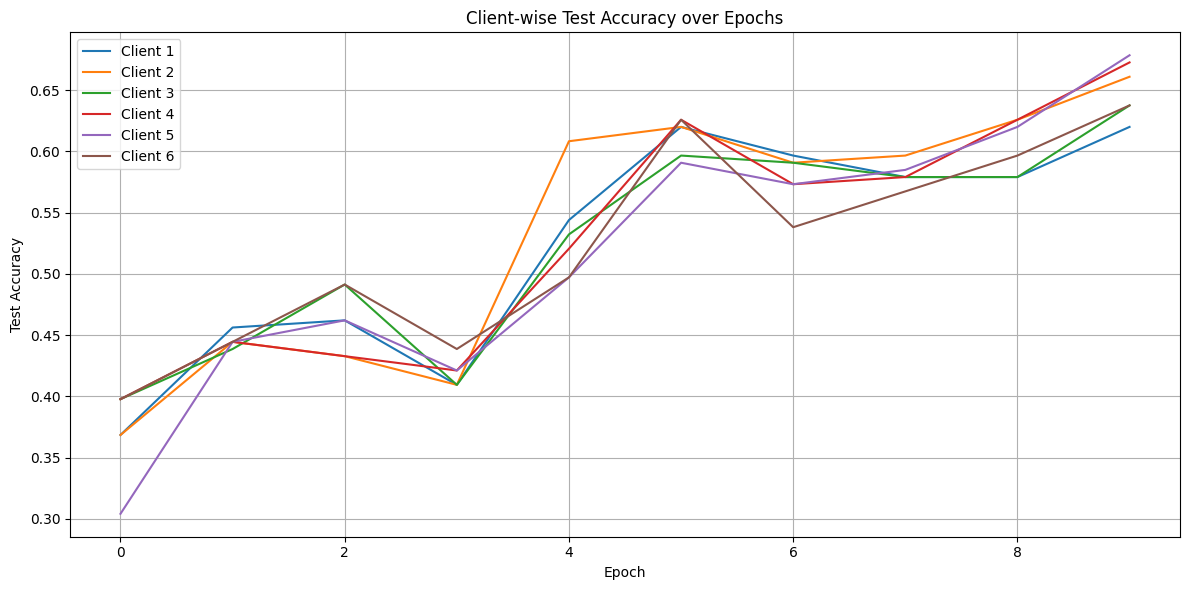

In [84]:
# ===============================
# 📈 Training & Test Accuracy Plot
# ===============================

plt.figure(figsize=(12, 6))
for i in range(num_clients):
    plt.plot(test_accuracies[i], label=f"Client {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Client-wise Test Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


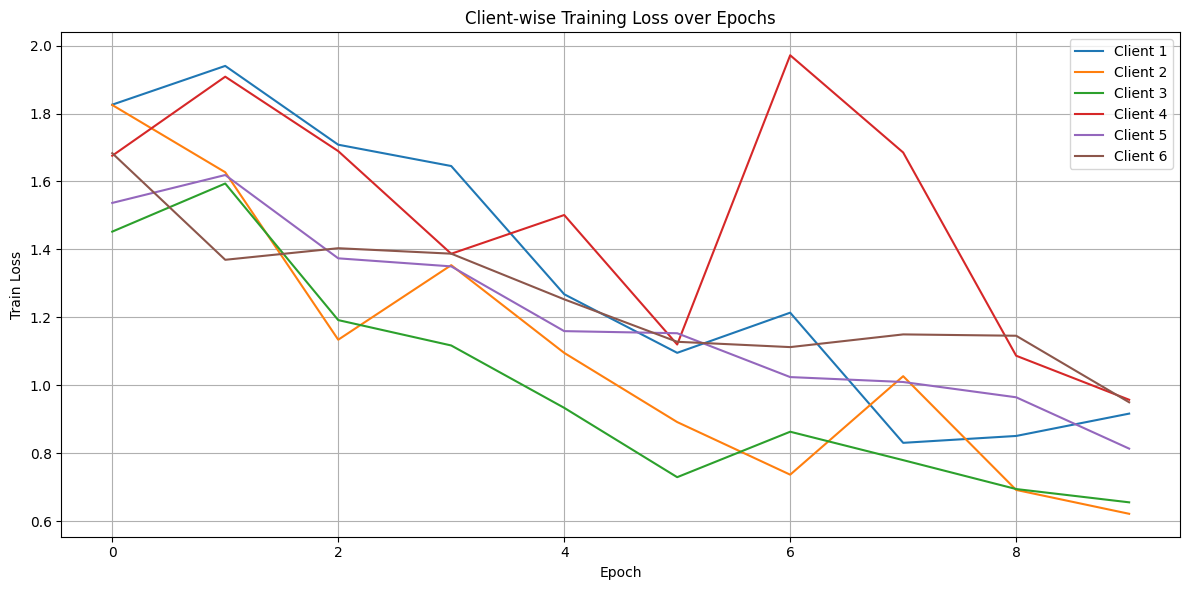

In [92]:
plt.figure(figsize=(12, 6))
for i in range(num_clients):
    plt.plot(train_losses[i], label=f"Client {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Client-wise Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [85]:
# ===============================
# ✅ Final Evaluation (Per Client)
# ===============================
final_test_accuracies = []

for client_idx in range(num_clients):
    # You can fix block depth for consistent comparison (e.g., final_block), or keep it random
    chosen_block = random.randint(initial_block, final_block)
    acc = trainer.eval_client(client_idx, chosen_block)
    final_test_accuracies.append(acc)
    print(f"Client {client_idx+1} Final Test Accuracy: {acc:.4f}")


Client 1 Final Test Accuracy: 0.6784
Client 2 Final Test Accuracy: 0.6608
Client 3 Final Test Accuracy: 0.6608
Client 4 Final Test Accuracy: 0.6199
Client 5 Final Test Accuracy: 0.6842
Client 6 Final Test Accuracy: 0.6725


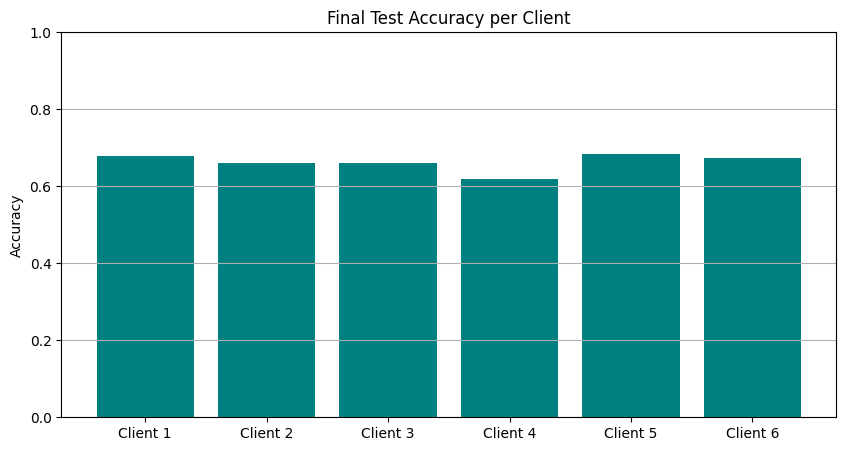

In [99]:
# ===============================
# 📊 Plot Final Accuracy Bar Chart
# ===============================
plt.figure(figsize=(10, 5))
plt.bar([f"Client {i+1}" for i in range(num_clients)], final_test_accuracies, color='teal')
plt.title("Final Test Accuracy per Client")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


In [ ]:
import pandas as pd

# Save results
df = pd.DataFrame({
    f"Client{i+1}_TestAcc": test_accuracies[i]
    for i in range(num_clients)
})
df.to_csv("fesvibs_test_accuracies.csv", index=False)

In [101]:
def evaluate_global(model, test_loader, num_clients, chosen_block=3, device='cuda'):
    """
    Evaluates the global model accuracy by averaging outputs from all clients.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.view(-1).to(device)

            # Collect predictions from each client
            client_outputs = []
            for client_idx in range(num_clients):
                out = model(x, chosen_block=chosen_block, client_idx=client_idx)
                client_outputs.append(out)

            # Average predictions across clients
            avg_output = torch.mean(torch.stack(client_outputs), dim=0)

            # Calculate accuracy
            preds = avg_output.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    acc = correct / total if total > 0 else 0.0
    print(f"🧠 Global Model Test Accuracy (Block {chosen_block}): {acc:.4f}")
    return acc


In [102]:
evaluate_global(model, test_loader, num_clients=num_clients, chosen_block=3, device=device)

🧠 Global Model Test Accuracy (Block 3): 0.6608


0.6608187134502924